In [2]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd

import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
import torch.utils.data as data
import torchvision.utils as v_utils
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import Dataset

In [2]:
%matplotlib inline

# Preprocessing

In [3]:
masks  =  pd.read_csv ('./train_ship_segmentations.csv')
masks.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...


In [3]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    #nan check
    if mask_rle != mask_rle:
        img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
        return img.reshape(shape).T
    
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [4]:
def create_mask(image_path):
    img_masks = masks.loc[masks['ImageId'] == image_path.split('/')[-1], 'EncodedPixels'].tolist()

    # Take the individual ship masks and create a single mask array for all ships
    masks_all = np.zeros((768, 768))
    for mask in img_masks:
        masks_all += rle_decode(mask)
    masks_all = np.minimum(masks_all, 1)*255
    tmp = np.array((masks_all, masks_all, masks_all), dtype=np.uint8)
    tmp = tmp.transpose(1,2,0)
    
    return tmp

## demo

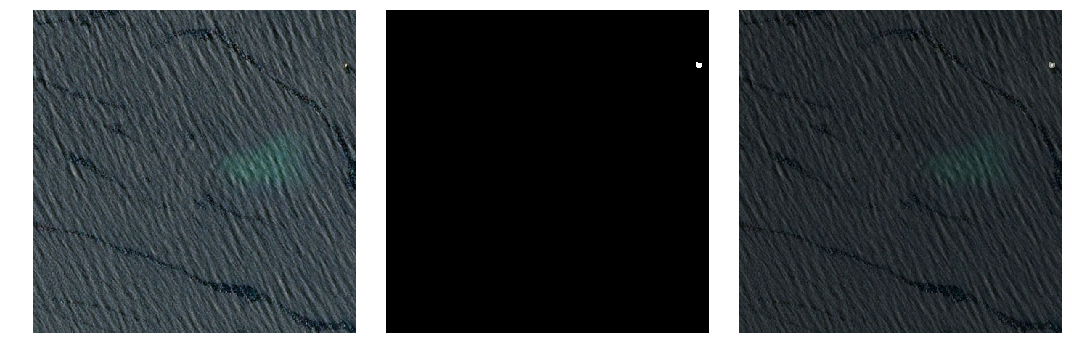

In [156]:
ImageId = '00053c6ba.jpg'

img = cv2.imread('./train/' + ImageId)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_masks = masks.loc[masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()

# Take the individual ship masks and create a single mask array for all ships
all_masks = np.zeros((768, 768))
for mask in img_masks:
    all_masks += rle_decode(mask)
    
all_masks = np.minimum(all_masks, 1)
fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[0].imshow(img)
axarr[1].imshow(all_masks)
axarr[2].imshow(img)
axarr[2].imshow(all_masks, alpha=0.4)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()


In [158]:
np.where((all_masks.T).flatten() == 1)

(array([565381, 565382, 565383, 566143, 566144, 566145, 566146, 566147,
        566148, 566149, 566150, 566151, 566908, 566909, 566910, 566911,
        566912, 566913, 566914, 566915, 566916, 566917, 566918, 566919,
        567676, 567677, 567678, 567679, 567680, 567681, 567682, 567683,
        567684, 567685, 567686, 567687, 567688, 568444, 568445, 568446,
        568447, 568448, 568449, 568450, 568451, 568452, 568453, 568454,
        568455, 568456, 569213, 569214, 569215, 569216, 569217, 569218,
        569219, 569220, 569221, 569222, 569223, 569224, 569981, 569982,
        569983, 569984, 569985, 569986, 569987, 569988, 569989, 569990,
        569991, 569992, 570749, 570750, 570751, 570752, 570753, 570754,
        570755, 570756, 570757, 570758, 570759, 570760, 570761, 571517,
        571518, 571519, 571520, 571521, 571522, 571523, 571524, 571525,
        571526, 571527, 571528, 571529, 572286, 572287, 572288, 572289,
        572290, 572291, 572292, 572293, 572294, 572295, 572296, 

In [1]:
def convert_runlength(convert_image):
    convert_image = cv2.resize(convert_image, (768, 768))
    flatten = np.where((convert_image.T).flatten() == 1)[0]
    runlength = ""
    count = 0
    if len(flatten) == 1:
        runlength = str(flatten[0]) + " 1"
        return runlength
    for i in range(len(flatten)):
        if i == 0:
            runlength = runlength +  str(flatten[i]) + " "
            count = 1
        elif i == len(flatten)-1:
            if flatten[i] == flatten[i-1]+1:
                count += 1
                runlength = runlength + str(count)
            else:
                runlength = runlength + str(count) + " " + str(flatten[i]) + " 1"
        else:
            if flatten[i] == flatten[i-1]+1:
                count += 1
            else:
                runlength = runlength + str(count) + " " + str(flatten[i]) + " "
                count = 1
    return runlength

# Make Dataset

In [5]:
class AirbusDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = os.listdir(root_dir)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, self.image_paths[idx])
        image = cv2.imread(image_path)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        masked_img = create_mask(image_path)
        if self.transform:
            image = self.transform(image)
            masked_img = self.transform(masked_img)
        return image, masked_img

In [43]:
class AirbusTestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = os.listdir(root_dir)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, self.image_paths[idx])
        image = cv2.imread(image_path)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image, self.image_paths[idx]

In [7]:
batch_size = 16
img_size = 256

In [11]:
train_dataset = AirbusDataset(root_dir='./train/', transform=transforms.Compose([
                                            transforms.ToPILImage(),
                                            transforms.Resize(size=img_size),
                                            transforms.ToTensor(),
                                            ]))
train_batch = data.DataLoader(train_dataset, batch_size=batch_size,
                            shuffle=True, num_workers=2)

# Make Network

In [9]:
def conv_block(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )
    return model


def conv_trans_block(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        nn.ConvTranspose2d(in_dim,out_dim, kernel_size=3, stride=2, padding=1,output_padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )
    return model


def maxpool():
    pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    return pool


def conv_block_2(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        conv_block(in_dim,out_dim,act_fn),
        nn.Conv2d(out_dim,out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
    )
    return model    


def conv_block_3(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        conv_block(in_dim,out_dim,act_fn),
        conv_block(out_dim,out_dim,act_fn),
        nn.Conv2d(out_dim,out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
    )
    return model

In [10]:
class UnetGenerator(nn.Module):

	def __init__(self,in_dim,out_dim,num_filter):
		super(UnetGenerator,self).__init__()
		self.in_dim = in_dim
		self.out_dim = out_dim
		self.num_filter = num_filter
		act_fn = nn.LeakyReLU(0.2, inplace=True)

		print("\n------Initiating U-Net------\n")

		self.down_1 = conv_block_2(self.in_dim,self.num_filter,act_fn)
		self.pool_1 = maxpool()
		self.down_2 = conv_block_2(self.num_filter*1,self.num_filter*2,act_fn)
		self.pool_2 = maxpool()
		self.down_3 = conv_block_2(self.num_filter*2,self.num_filter*4,act_fn)
		self.pool_3 = maxpool()
		self.down_4 = conv_block_2(self.num_filter*4,self.num_filter*8,act_fn)
		self.pool_4 = maxpool()

		self.bridge = conv_block_2(self.num_filter*8,self.num_filter*16,act_fn)

		self.trans_1 = conv_trans_block(self.num_filter*16,self.num_filter*8,act_fn)
		self.up_1 = conv_block_2(self.num_filter*16,self.num_filter*8,act_fn)
		self.trans_2 = conv_trans_block(self.num_filter*8,self.num_filter*4,act_fn)
		self.up_2 = conv_block_2(self.num_filter*8,self.num_filter*4,act_fn)
		self.trans_3 = conv_trans_block(self.num_filter*4,self.num_filter*2,act_fn)
		self.up_3 = conv_block_2(self.num_filter*4,self.num_filter*2,act_fn)
		self.trans_4 = conv_trans_block(self.num_filter*2,self.num_filter*1,act_fn)
		self.up_4 = conv_block_2(self.num_filter*2,self.num_filter*1,act_fn)

		self.out = nn.Sequential(
			nn.Conv2d(self.num_filter,self.out_dim,3,1,1),
			nn.Tanh(),
		)

	def forward(self,input):
		down_1 = self.down_1(input)
		pool_1 = self.pool_1(down_1)
		down_2 = self.down_2(pool_1)
		pool_2 = self.pool_2(down_2)
		down_3 = self.down_3(pool_2)
		pool_3 = self.pool_3(down_3)
		down_4 = self.down_4(pool_3)
		pool_4 = self.pool_4(down_4)

		bridge = self.bridge(pool_4)

		trans_1 = self.trans_1(bridge)
		concat_1 = torch.cat([trans_1,down_4],dim=1)
		up_1 = self.up_1(concat_1)
		trans_2 = self.trans_2(up_1)
		concat_2 = torch.cat([trans_2,down_3],dim=1)
		up_2 = self.up_2(concat_2)
		trans_3 = self.trans_3(up_2)
		concat_3 = torch.cat([trans_3,down_2],dim=1)
		up_3 = self.up_3(concat_3)
		trans_4 = self.trans_4(up_3)
		concat_4 = torch.cat([trans_4,down_1],dim=1)
		up_4 = self.up_4(concat_4)

		out = self.out(up_4)

		return out

In [6]:
recon_loss_func = nn.MSELoss()
generator = nn.DataParallel(UnetGenerator(3,3,64),device_ids=[0]).cuda()

lr = 0.002
gen_optimizer = torch.optim.Adam(generator.parameters(),lr=lr)


------Initiating U-Net------



RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1512387374934/work/torch/lib/THC/generic/THCStorage.cu:58

# Training

In [144]:
import slack_notification as sn

In [ ]:
epoch = 10
file = open('./unet_mse_loss', 'w')
for i in range(epoch):
    for _, (images,img_masks) in enumerate(train_batch):
        gen_optimizer.zero_grad()

        x = Variable(images).cuda(0)
        y_ = Variable(img_masks).cuda(0).float()
        y = generator.forward(x)
        
        loss = recon_loss_func(y,y_)
        file.write(str(loss)+"\n")
        loss.backward()
        gen_optimizer.step()

        if _ % 400 ==0:
            print(i)
            print(loss)
            v_utils.save_image(x.cpu().data,"./result/original_image_{}_{}.png".format(i,_))
            v_utils.save_image(y_.cpu().data,"./result/label_image_{}_{}.png".format(i,_))
            v_utils.save_image(y.cpu().data,"./result/gen_image_{}_{}.png".format(i,_))
            torch.save(generator,'./model/unet_{}_{}.pkl'.format(i,_))    
            
            sn.send_notification(text = 'finish: epoch {}, batch_idx {}'.format(i,_))


0
Variable containing:
1.00000e-03 *
  1.5584
[torch.cuda.FloatTensor of size 1 (GPU 0)]



/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type UnetGenerator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0
Variable containing:
1.00000e-04 *
  9.9601
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0
Variable containing:
1.00000e-03 *
  1.8720
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0
Variable containing:
1.00000e-04 *
  1.9106
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0
Variable containing:
1.00000e-04 *
  3.2335
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0
Variable containing:
1.00000e-04 *
  8.7643
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0
Variable containing:
1.00000e-04 *
  7.9865
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0
Variable containing:
1.00000e-04 *
  4.8248
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0
Variable containing:
1.00000e-04 *
  5.9784
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0
Variable containing:
1.00000e-04 *
  1.0762
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0
Variable containing:
1.00000e-04 *
  1.8612
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0
Variable containing:
1.00000e-04 *
  2.5030
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0
Variable

# evaluation

evaluationだけする場合もUnetクラスを実行する必要あり

In [44]:
test_dataset = AirbusTestDataset(root_dir='./test/', transform=transforms.Compose([
                                            transforms.ToPILImage(),
                                            transforms.Resize(size=img_size),
                                            transforms.ToTensor(),
                                            ]))
test_batch = data.DataLoader(test_dataset, batch_size=batch_size,
                            shuffle=True, num_workers=2)

In [11]:
model = torch.load("./model/unet_4_800.pkl")

In [211]:
def test_sample():
    count = 0
    for _, (image, image_paths) in enumerate(test_batch):
        if count >= 1:
            break
        count += 1
        image = Variable(image)
        outputs = (model(image).data).cpu().numpy()
        out_img = outputs[0].transpose(1,2,0)
        out_img = np.maximum(out_img, 0)
        out_img = np.minimum(out_img, 1)
        out_gray = np.mean(out_img, axis=2)
        
        thresh = 0.2
        max_pixel = 1
        _, out_thresh = cv2.threshold(out_gray, thresh, max_pixel, cv2.THRESH_BINARY)
        
        out_thresh = cv2.resize(out_thresh, (768, 768))
        rl = convert_runlength(out_thresh)
        decoded_img = rle_decode(rl)
        print(rl)
        
        
        original_img = cv2.imread('./test/{}'.format(image_paths[0]))
        fig, axarr = plt.subplots(1, 4, figsize=(15, 40))

        axarr[0].imshow(out_gray)
        axarr[1].imshow(out_thresh)
        axarr[2].imshow(original_img)
        axarr[3].imshow(decoded_img)
        plt.tight_layout(h_pad=0.1, w_pad=0.1)
        plt.show()

282202 7 282970 7 283738 7 284506 7 285274 4 286042 4 286810 4


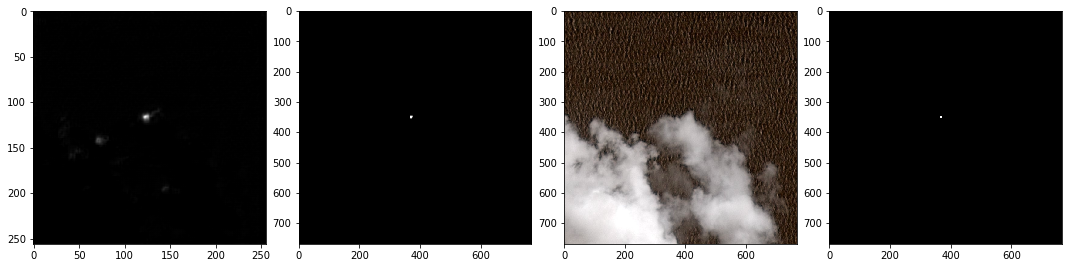

In [229]:
test_sample()

In [230]:
ignore_images = ['13703f040.jpg',
                 '14715c06d.jpg',
                 '33e0ff2d5.jpg',
                 '4d4e09f2a.jpg',
                 '877691df8.jpg',
                 '8b909bb20.jpg',
                 'a8d99130e.jpg',
                 'ad55c3143.jpg',
                 'c8260c541.jpg',
                 'd6c7f17c7.jpg',
                 'dc3e7c901.jpg',
                 'e44dffe88.jpg',
                 'ef87bad36.jpg',
                 'f083256d8.jpg']

In [241]:
def test():
    index = 0
    df = pd.DataFrame({'ImageId': [], 'EncodedPixels': []})
    df = df[['ImageId', 'EncodedPixels']]
    
    for _, (image, image_paths) in enumerate(test_batch):
        image = Variable(image)
        outputs = (model(image).data).cpu().numpy()
        for img_name, out_img in zip(image_paths, outputs):
            if img_name in ignore_images:
                continue
            out_img = out_img.transpose(1,2,0)
            out_img = np.maximum(out_img, 0)
            out_img = np.minimum(out_img, 1)
            out_gray = np.mean(out_img, axis=2)
        
            thresh = 0.2
            max_pixel = 1
            _, out_thresh = cv2.threshold(out_gray, thresh, max_pixel, cv2.THRESH_BINARY)
        
            out_thresh = cv2.resize(out_thresh, (768, 768))
            rl = convert_runlength(out_thresh)
            
            df.loc[index] = [img_name, rl]
            if index % 2000 == 0:
                df.to_csv('submission_0802.csv', header=True, index=False)
                sn.send_notification(text='{} tests done'.format(index))
            index += 1
            
    df.to_csv('submission_0802.csv', header=True, index=False)
    sn.send_notification(text='all done'.format(index))

In [242]:
test()